In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statistics
import seaborn as sns
import re 
from operator import itemgetter
from statannot import add_stat_annotation
import warnings
warnings.filterwarnings('ignore')
from scipy import optimize
from scipy.optimize import curve_fit,minimize
from scipy.integrate import solve_ivp
from sklearn.metrics import r2_score
import statistics

## Summary of the functions:

### 1. excelreader:
   - function to open the excel file of the results 
   - imputs : name of the file .xlsx , the gain you want to use (from 50 to 100),  if you want the correction to go back to FITC equivalent type Yes or YES  if you don't want the correction type "NO" 
  
   
### 2. plot_raw_data:
   - function to plot the raw data
   - imputs : the data you want to use (you can call it using the excelreader output) , the number of row for display, the number of columns for display (if the number of conditions is odd you can add one and add a row or a column )
   
### 3. collapse: 
   - function to collapse the triplicate into one column
   - imputs : the data (dataframe) , how you made the triplicate either 'line' 'col' or if you did not do triplicate 'no', the position of the control well with only H2O in this synthax : ['I2','I3','I4']
   
### 4. plot_triplicates
   - function to plot the mean of all the triplicate 
   - imputs : the collapsed dataset, if you want the plots in the same axis or not ("YES" or "NO")

In [2]:
def excelreader(name,gain,correct):
    
    time_points = 0 
    #open the file 
    
    df_cellfree = pd.ExcelFile(name)
    
    # find the machine name to know where data start 
    
    test = pd.DataFrame(df_cellfree.parse(0))

    if re.search('Synergy',str(test.iloc[7,1])) == None :
        
        s = 64
        
        correction = [3720.7,39499,47364,192405]

    else: 
        s = 67
        
        correction = [5929.3,57884,73091,283567]
        
        
        
    #find the number of time points
    
    if s == 67:
        
        time_points = int(re.findall(r'\d+',test.iloc[17,1])[-1])

    else : 
        
        time_points = int(re.findall(r'\d+',test.iloc[16,1])[-1])
        
    # "crop" the table depending on the gain set 
    
    if gain == 50 :
        df_Fcellfree = pd.DataFrame(df_cellfree.parse(0).values[s+12+(3*time_points):s+13+(4*time_points)])
        c = correction[0]
    elif gain == 70 : 
        df_Fcellfree = pd.DataFrame(df_cellfree.parse(0).values[s+8+(2*time_points):s+9+(3*time_points)])
        c = correction[1]
    elif gain == 75 : 
        df_Fcellfree = pd.DataFrame(df_cellfree.parse(0).values[s+4+time_points:s+5+(2*time_points)])
        c = correction[2]
    elif gain == 100 : 
        df_Fcellfree = pd.DataFrame(df_cellfree.parse(0).values[s:s+1+time_points])
        c = correction[3]

    # Label first row as  column names
    df_Fcellfree.columns = df_Fcellfree.iloc[0]
    

    # Drop the first row (Which is column names)
    df_Fcellfree = df_Fcellfree.iloc[1: , :]
    
    
    # Drop the First Column ---> Generates "NAN column"
    df_Fcellfree = df_Fcellfree.iloc[: , 1:]
    
    
    remove = np.asarray(df_Fcellfree.columns)
    
    
    df_Fvalues = df_Fcellfree.reset_index().drop([remove[0],remove[1],'index'],axis = 1).astype('float64')
    
    
    if correct == "NO":
        df_Fvalues = df_Fvalues  
    else:
        df_Fvalues = df_Fvalues/c # the calibration to go back to µM 
    
    time_list = [0]
    n_rows = df_Fvalues.shape[0]
    time_interval =  5 # minutes
    time = 0
    for i in range(n_rows):
        time += time_interval
        time_list.append(time)

    df_Tvalues = pd.DataFrame([time_list]).transpose().rename(columns={0:'Time'})
    
    df_Fvalues['Time'] = df_Tvalues['Time']

    return (df_Fvalues)

In [3]:
def plot_raw_data(data,nr,nc):
    fig,axs = plt.subplots(nr, nc, sharex = True, sharey = True,figsize=(30, 30))
    counter = 0
    for i in range(nr):
        for j in range(nc):
            axs[i,j].plot(data['Time'],data[data.columns[counter]])
            counter+=1
    plt.show()

In [4]:
def collapse(data,tripl,control):
    
    #create a variable with names of the columns
    
    col=[]
    name =[]
    
    for ch in data.columns[:-1]:
        col.append(ch)

    #if the imput is line then the triplicate are a list of the column name 3 by 3 
    
    if tripl == 'line': 

        i = 0
        j = 0
        while i < round((len(col)/3),0):
            name.append([col[j],col[j+1],col[j+2]])
            i= i +1
            j = j+3 
            
    elif tripl == 'col':
        
        #create a list of the repeating letters
        duplicates = []
        for char in re.findall('[a-zA-Z]',str(col)):
            ## checking whether the character have a duplicate or not
            ## str.count(char) returns the frequency of a char in the str
            if str(col).count(char) > 1:
                []
            ## appending to the list if it's already not present

            if char not in duplicates :

                duplicates.append(char)
        
        #create a list of the repeated number
        b = list(np.array_split(re.findall(r'\d+ ?',str(col)),len(duplicates))[0])

        #for each repeating number add the repeating letter 

        li = []

        for i in b :
            for j in duplicates :
                li.append(j+str(i))


        #create a list of list containing 3 by 3 the name of the previous list

        i = 0 
        j = 0
        name=[]
        
              
        while i < len(li)/3:
            name.append([li[j],li[j+1],li[j+2]])
            i= i +1
            j = j+3  

    else : 
        name = col
        
    pos = []
    collapse = name
    
    list_bg = control
    
    df_Fbg = data[list_bg]
    df_Fbg['mean'] = df_Fbg.mean(axis=1)
    
    for col,i in zip(collapse,range(len(collapse))):

        list_flu = collapse
        df_flu = data[col]
        df_flu['mean'] = df_flu.mean(axis=1)
        df_flu['cor'] = df_flu['mean']-df_Fbg['mean']

        # Build the Backgruond Table...
        # TIME
        df_flut = data['Time']

        # MEAN
        df_flut['mean'] = df_flu['mean']
        df_flut['cor'] = df_flu['cor']

        #df_flut.head()

        data[str(col)] = df_flut['cor']
    
    for i in range(len(name)):
        pos.append(str(name[i]))
    
    df_Fcollapse = data[pos]
    df_Fcollapse['Time'] = data['Time']
    
    df_Fcollapse[df_Fcollapse<0]=0
    
    return (df_Fcollapse)

In [5]:
def plot_triplicates(data,sa):
    std = []
    for i in data.columns.values[:-1]:
        std.append(statistics.stdev(data[i]))

    if sa == "NO":
        for col,i in zip(data.columns,range(len(data.columns.values)-1)):
            plt.errorbar(data['Time'],data[col],yerr=std[i],label=data.columns.values[:-1][i])
            plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
            plt.show()
    elif sa =="YES":
        for col,i in zip(data.columns,range(len(data.columns.values)-1)):
            plt.errorbar(data['Time'],data[col],yerr=std[i],label=data.columns.values[:-1][i])
            plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

In [6]:
def main(data,gain,cor,nr,nc,tripl,control,sa):
    
    file = excelreader(data,gain,cor)
    
    #plot_raw_data(file,nr,nc)
    
    fileC = collapse(file,tripl,control)
        
    #plot_triplicates(fileC,sa)
    
    return fileC

# test

df_init = main('11.03.22 cell free.xlsx',75,"YES",6,8,'col',['E22', 'F22', 'G22'],"YES")

df_init.head()

,"['B15', 'C15', 'D15']","['E15', 'F15', 'G15']","['B16', 'C16', 'D16']","['E16', 'F16', 'G16']","['B17', 'C17', 'D17']","['E17', 'F17', 'G17']","['B18', 'C18', 'D18']","['E18', 'F18', 'G18']","['B19', 'C19', 'D19']","['E19', 'F19', 'G19']","['B20', 'C20', 'D20']","['E20', 'F20', 'G20']","['B21', 'C21', 'D21']","['E21', 'F21', 'G21']","['B22', 'C22', 'D22']","['E22', 'F22', 'G22']",Time
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000292,0.000000,0.000000,0.000105,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0
1,0.000369,0.000196,0.000251,0.000205,0.000502,0.000625,0.000301,0.000000,0.000383,0.000014,0.000315,0.000246,0.000000,0.000036,0.000000,0.0,5
2,0.000474,0.000000,0.000315,0.000219,0.000616,0.000379,0.000351,0.000000,0.000702,0.000000,0.000556,0.000073,0.000014,0.000036,0.000205,0.0,10
3,0.001104,0.000233,0.001090,0.000438,0.001172,0.000169,0.000848,0.000091,0.001113,0.000141,0.000949,0.000000,0.000825,0.000369,0.000643,0.0,15
4,0.001391,0.000246,0.001450,0.000347,0.001240,0.000337,0.000953,0.000962,0.001546,0.000985,0.000725,0.000046,0.001897,0.002007,0.000702,0.0,20


# Modeling the dynamics

 From the article [Stogbauer et al](https://doi.org/10.1039/C2IB00102K) we can use their equations:
 
 $$ \frac{dGFP}{dt}=\frac{k_{tl}*R_{e}*mRNA}{K_{1}+mRNA}-k_{mat}*GFP $$ 
 and 
 $$ \frac{dmRNA}{dt}= \frac{k_{ts}*R_{e}*DNA}{K_{2}+DNA}-\delta_{mRNA}*mRNA $$
 
 With ![image](https://pubs.rsc.org/en/Image/Get?imageInfo.ImageType=GA&imageInfo.ImageIdentifier.ManuscriptID=C2IB00102K&imageInfo.ImageIdentifier.Year=2012) and $R_{e} = \delta_{TsR} = \delta_{TlR}$ also $ K_{1} , K_{2}$ are michaelis menten constant and account for binding constant of ribosome /DNA pol.
 
 From these equation we can simplify it by assuming :
- the DNA concentration to be stable because it is not degraded and stable in solution.
- We can also assume the rate of transcription and the amount of mRNA more or less constant (not measured here) and implement it inside the $R_{e}$ which we will call the ressource factor (which rules the steady state) 
- the maturation of GFP is negligible because we are working with sfGFP
 
We are left with:
 $$ \frac{dGFP}{dt}=\frac{k_{tl}*R_{e}*GFP}{K_{1}+GFP} - \alpha GFP$$ 

## Steps: 

- Define a function that will compute the derivative
- Give initial parameters
- Define a function that will compute the error comparing the integrated function and the experimental data
- import the data
- minimize the error function with the experimental data
- plot the results

   

# Proof of concept

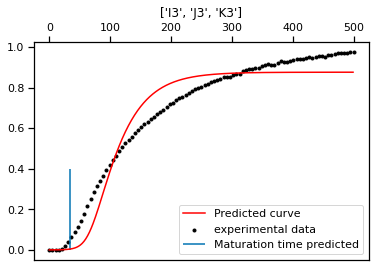

The total sum of squares is 0.544399940246997
The r² for this fit is 0.9430317786583833


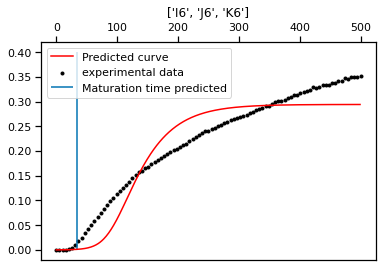

The total sum of squares is 0.11744261618864654
The r² for this fit is 0.9038779250259743


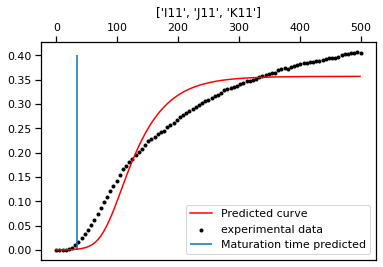

The total sum of squares is 0.10653386487604952
The r² for this fit is 0.9383436277681039


In [154]:
def f(time,a,param):
    k = param[0] #translation rate
    R = param[1] #Ressource factor
    K = param[2] #michaelis menten constant
    j = param[3] #maturation rate 
    GFP = [(k*R*a)/(K+a)-(j*a)]
    return GFP

times = np.linspace(0,500,97)
t = np.linspace(0,500,500)
parami = [0.02215796070459225, 0.33069047222295544, 0.08509235762103393, 0.03]
a = 0.0001 # 1 nM

def error(param,obs):
    
    times = np.linspace(0,500,97)
    t = np.linspace(0,500,500)
    
    sol = solve_ivp(f,t_span =[0, times.max()], y0= [a] , args =([param]),t_eval=times,method='DOP853',dense_output=True,rtol=1e-8,atol=1e-8)
    
    z = sol.sol(times)
    
    err = []
        
    for i in range(len(z.tolist()[0])):
        err.append((obs[i]-z.tolist()[0][i])**2)    
    
    erro= np.sum(err)

    return erro

prod = []
ressource = []

for i in df_init.columns[:-1]:
    
    data = df_init[i]
    res = minimize(error, parami, args=(data),bounds=[(0,10),(0,10),(0,10),(0.03,0.05)])

    result = solve_ivp(f,t_span =[0, times.max()], y0= [a] , args =([list(res.x)]),t_eval=times,method='DOP853',dense_output=True)
    j = result.sol(t)
    k = result.sol(times)
    if r2_score(k.T,data) >0.9:
        
        prod.append(list(res.x)[0])
        ressource.append(list(res.x)[1])
        plt.plot(j.T,label = "Predicted curve",color = "red")
        plt.scatter(times,data,color='black',marker = '.',label = "experimental data")
        plt.title(i)
        plt.vlines(1/list(res.x)[3],0,0.4,label = "Maturation time predicted")
        plt.legend()
        plt.show()
    
        print('The total sum of squares is '+ str(error(list(res.x),data)))
        print('The r² for this fit is '+ str(r2_score(k.T,data)))


# Modeling integrase behaviour

In [155]:
#create a subset dataframe containing the integrase columns 

intcol = ["['B20', 'C20', 'D20']","['B21', 'C21', 'D21']","['B22', 'C22', 'D22']","['B15', 'C15', 'D15']","['B16', 'C16', 'D16']", "['B17', 'C17', 'D17']","['B18', 'C18', 'D18']","['B19', 'C19', 'D19']"]
intcol.sort()
name = ["Tp901 Not","Tp901 ID","Bxb1 Not","Bxb1 ID","Int5 Not","Int5 ID","Int7 Not","Int7 ID"]

ints = pd.DataFrame()
std = []
for i in range(len(intcol)):
    ints[name[i]] = df_init[intcol[i]]

#create list that will contain production rate and ressource factor

prod_integrases = []
ressource_E26= []

#loop over all columns and model
sns.set_context("paper")

for i in ints.columns:
    
    data = ints[i]
    res = minimize(error, parami, args=(data),bounds=[(0,10),(0,10),(0,10),(0.03,0.05)])

    result = solve_ivp(f,t_span =[0, times.max()], y0= [a] , args =([list(res.x)]),t_eval=times,method='DOP853',dense_output=True)
    j = result.sol(t)
    k = result.sol(times)
    if r2_score(k.T,data) >0.9:
        
        prod_integrases.append(list(res.x)[0])
        ressource_E26.append(list(res.x)[1])
        plt.plot(j.T,label = "Predicted curve",color = "red")
        plt.scatter(times,data,color='black',marker = '.',label = "experimental data")
        plt.title(i)
        plt.vlines(1/list(res.x)[3],0,0.4,label = "Maturation time predicted")
        plt.ylabel('Equivalent FITC(µM)')
        plt.xlabel('Time(minutes)')
        plt.legend()
        plt.show()
    
        print('The total sum of squares is '+ str(error(list(res.x),data)))
        print('The r² for this fit is '+ str(r2_score(k.T,data)))

KeyError: "['B15', 'C15', 'D15']"

In [137]:
print('The average production rate is '+ str(round(np.mean(prod),2))+ u" \u00B1 " + str(round(statistics.stdev(prod),2))+' µM min-1')
print('The average ressource factor is '+ str(round(np.mean(ressource),2))+ u" \u00B1 " + str(round(statistics.stdev(ressource),2))+' µM')

The average production rate is 0.03 ± 0.02 µM min-1
The average ressource factor is 0.34 ± 0.01 µM


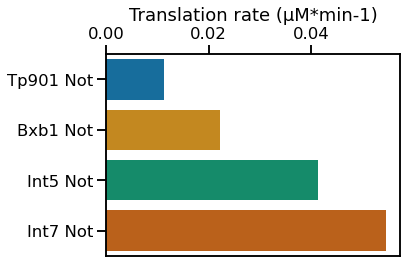

In [37]:
plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = False
plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = True

sns.set_context("talk")
sns.barplot(x=prod_integrases,y=["Tp901 Not","Bxb1 Not","Int5 Not","Int7 Not"],palette='colorblind')
plt.title('Translation rate (µM*min-1)')
plt.tight_layout()
plt.savefig('plots/modeling_integrases.png',dpi=300)
plt.show()

In [161]:
print(prod_integrases)

[0.01135728096740565, 0.02215796070459225, 0.0412999379479496, 0.05461656129787905]


## Comparing metrics for integrases 

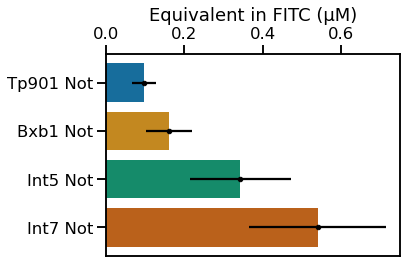

In [43]:
plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = False
plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = True

df_init = main('11.03.22 cell free.xlsx',75,"YES",6,8,'col',['E22', 'F22', 'G22'],"YES")

intcol = ["['B21', 'C21', 'D21']","['B15', 'C15', 'D15']","['B17', 'C17', 'D17']","['B19', 'C19', 'D19']"]
intcol.sort()
name = ["Tp901 Not","Bxb1 Not","Int5 Not","Int7 Not"]

ints = pd.DataFrame()
std = []
for i in range(len(intcol)):
    ints[name[i]] = df_init[intcol[i]]
for j in ints.columns:
    std.append(statistics.stdev(ints[j]))   


sns.set_context("talk") 

sns.barplot(x=ints.values[-1],y=ints.columns.values,palette='colorblind')
plt.errorbar(ints.values[-1], ints.columns.values, xerr=std,ecolor='black',fmt='.k')
plt.xlabel("")
plt.title("Equivalent in FITC (µM)")
plt.tight_layout()
plt.savefig('plots/Simple Integrases_copare_metrics.png',dpi=300)
plt.show()

### Plot in the same axis

               data     model
Tp901 Not  0.097230  0.011357
Bxb1 Not   0.161164  0.022158
Int5 Not   0.343622  0.041300
Int7 Not   0.541348  0.054617


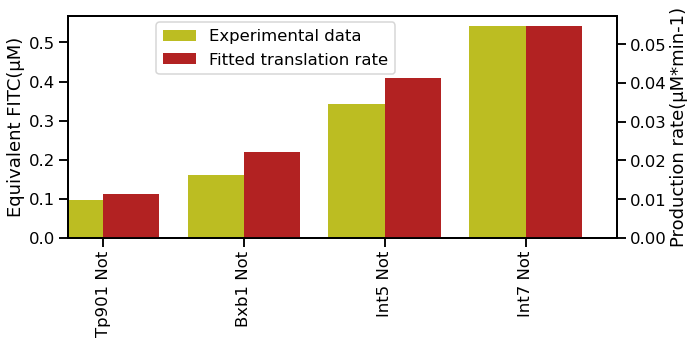

In [136]:
plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = True
plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = False

df= pd.DataFrame(data = ints.values[-1],index=ints.columns.values)
df[1]= prod_integrases
df = df.rename(columns={df.columns[0]:"data",df.columns[1]:"model"})
print(df.head())

fig = plt.figure()
# Create matplotlib figure

fig.set_size_inches(10, 5)

ax = fig.add_subplot(111)
ax2 = ax.twinx()

sns.set_context("talk")

df.data.plot(kind='bar', color="tab:olive",ax=ax, width=0.4, position=1,label="Experimental data")
df.model.plot(kind='bar', color="firebrick", ax=ax2, width=0.4, position=0,label="Fitted translation rate")
fig.legend(loc='upper center', bbox_to_anchor=(0.4,0.95))
ax.set_ylabel("Equivalent FITC(µM)")
ax2.set_ylabel("Production rate(µM*min-1)")
plt.tight_layout()
plt.savefig('plots/comp_fit_exp.png',dpi=300)
plt.show()



# Comparing the ressource factor between extract

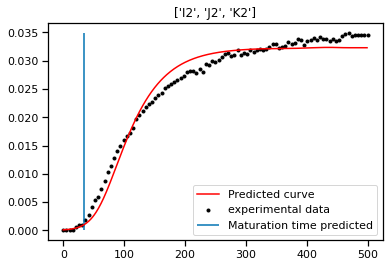

The total sum of squares is 0.00024986068501528177
The r² for this fit is 0.979104053398057
[0.0007275311403506864, 1.897527934208785, 0.013715646259411952, 0.03]


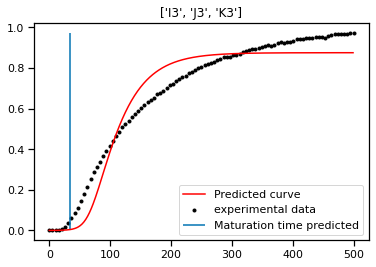

The total sum of squares is 0.5443999402512342
The r² for this fit is 0.9430317431324724
[0.05992863909370623, 0.5578120083309948, 0.23889318671936413, 0.03]


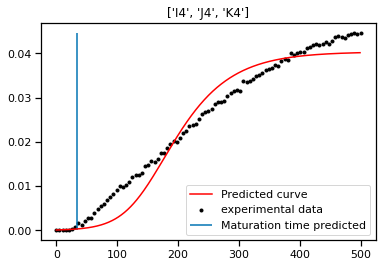

The total sum of squares is 0.0010273832782739445
The r² for this fit is 0.9574324057795002
[0.004462742897052473, 0.5032582932471009, 0.03454329968679014, 0.03]


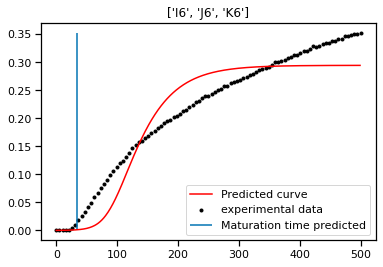

The total sum of squares is 0.11744261619221245
The r² for this fit is 0.9038778375313897
[0.024305590058256405, 0.5136510413709904, 0.12179313417574844, 0.03]


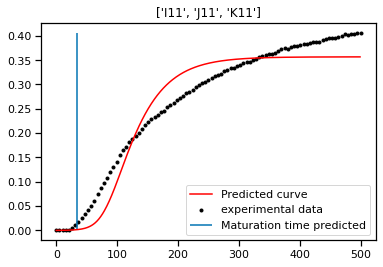

The total sum of squares is 0.10653386488030137
The r² for this fit is 0.9383435601396318
[0.028319180002761093, 0.5173344110783473, 0.13154517037004532, 0.03]


In [145]:
df_init = main('andnotCF.xlsx',75,"YES",3,8,'col',['I12', 'J12', 'K12'],"YES")

prod_2_imputs = []
ressource_2_imputs = []
sns.set_context('notebook')

parami = [0.01, 0.5, 0.08, 0.03]

for i in df_init.columns[:-1]:
    
    data = df_init[i]
    res = minimize(error, parami, args=(data),bounds=[(0,10),(0,10),(0,10),(0.03,0.05)])

    result = solve_ivp(f,t_span =[0, times.max()], y0= [a] , args =([list(res.x)]),t_eval=times,method='DOP853',dense_output=True)
    j = result.sol(t)
    k = result.sol(times)
    if r2_score(k.T,data) >0.9:
        
        prod_2_imputs.append(list(res.x)[0])
        ressource_2_imputs.append(list(res.x)[1])
        plt.plot(j.T,label = "Predicted curve",color = "red")
        plt.scatter(times,data,color='black',marker = '.',label = "experimental data")
        plt.title(i)
        plt.vlines(1/list(res.x)[3],0,max(data),label = "Maturation time predicted")
        plt.legend()
        plt.show()
    
        print('The total sum of squares is '+ str(error(list(res.x),data)))
        print('The r² for this fit is '+ str(r2_score(k.T,data)))
        print(list(res.x))

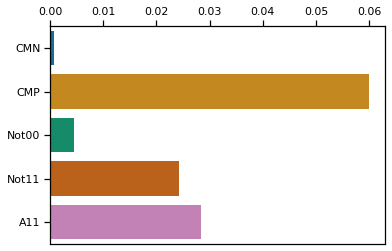

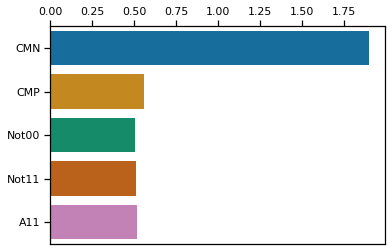

In [151]:
plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = False
plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = True

sns.barplot(y=['CMN','CMP','Not00','Not11','A11'],x=prod_2_imputs,palette='colorblind')
plt.show()

sns.barplot(y=['CMN','CMP','Not00','Not11','A11'],x=ressource_2_imputs,palette='colorblind')
plt.show()

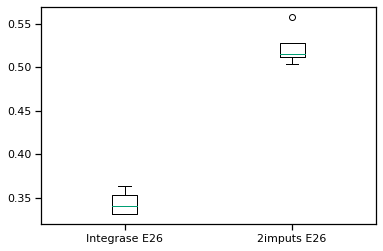

In [160]:
plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = True
plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = False

plt.boxplot([ressource_E26,ressource_2_imputs[1:]])
plt.xticks([1,2],["Integrase E26","2imputs E26"])
plt.show()

# Other ideas : plot the derivative production over time

Fit data with logistic -> compute the derivative -> calculate max rate -> calculate time for max rate

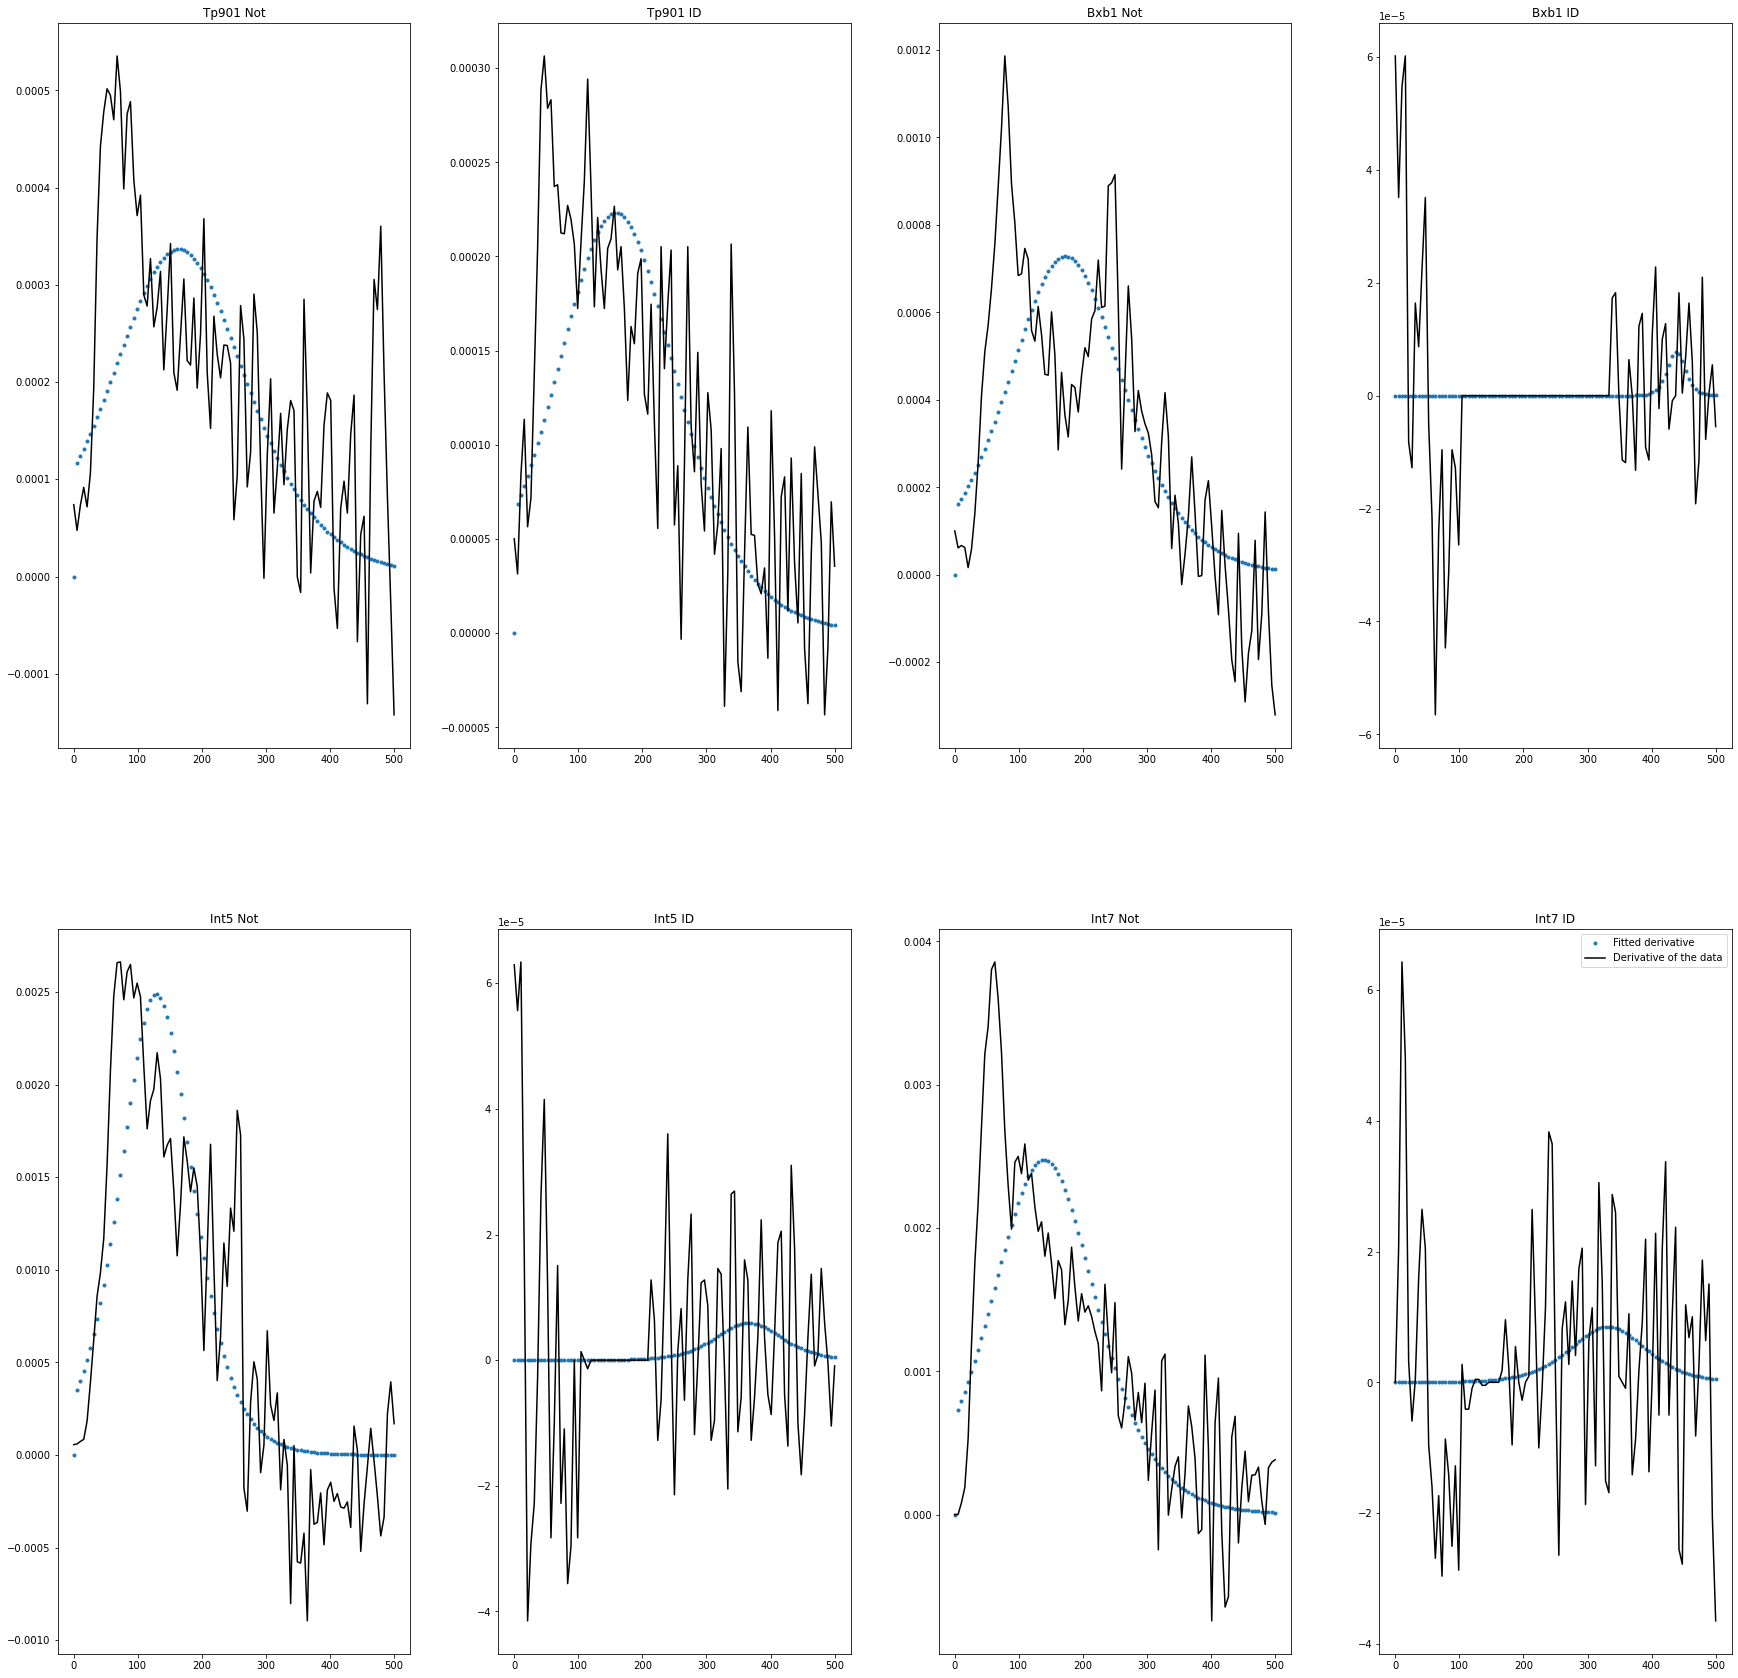

In [7]:
fig = plt.figure(figsize=(30, 30))

df_init = main('11.03.22 cell free.xlsx',75,"YES",6,8,'col',['E22', 'F22', 'G22'],"YES")

intcol = ["['B20', 'C20', 'D20']","['B21', 'C21', 'D21']","['B22', 'C22', 'D22']","['B15', 'C15', 'D15']","['B16', 'C16', 'D16']", "['B17', 'C17', 'D17']","['B18', 'C18', 'D18']","['B19', 'C19', 'D19']"]
intcol.sort()
name = ["Tp901 Not","Tp901 ID","Bxb1 Not","Bxb1 ID","Int5 Not","Int5 ID","Int7 Not","Int7 ID"]


ints = pd.DataFrame()

for i in range(len(intcol)):
    ints[name[i]] = df_init[intcol[i]]

rows = 2
columns = 4
grid = plt.GridSpec(rows, columns, wspace = .25, hspace = .25)

div_mean = []
rate = []
alphamax = []

def slope(listy,timestep):
    listydiff=[0]
    i=0
    while i < len(listy)-1:
        dely = listy[i+1]-listy[i]
        delx = timestep
        listydiff.append(dely/delx)
        i = i +1 
    return listydiff

def logifunc(x,A,x0,k,off):
    return A / (1 + np.exp(-k*(x-x0)))+off

maxim = []
times = np.linspace(0,500,97)

for i in range(rows*columns):
    exec (f"plt.subplot(grid{[i]})")
    popt1,pcov=curve_fit(logifunc,times,ints[ints.columns[i]],method="trf" ,maxfev=10000,
                         bounds = ([0,0,0,min(ints[ints.columns[i]])],[max(ints[ints.columns[i]]),1000,0.2,max(ints[ints.columns[i]])]))
    plt.plot(times, slope(logifunc(times, *popt1),5), '.',label='Fitted derivative')
    rate.append(np.mean(slope(logifunc(times, *popt1),5)))
    alphamax.append(max(slope(logifunc(times, *popt1),5)))
    plt.plot(times,np.gradient(ints[ints.columns[i]])/5,'-',color = 'black',label="Derivative of the data")
    maxim.append(max(np.gradient(ints[ints.columns[i]])/5))
    plt.title(ints.columns[i])
    #plt.ylim(0,0.001)
    
    
plt.legend()
plt.show()

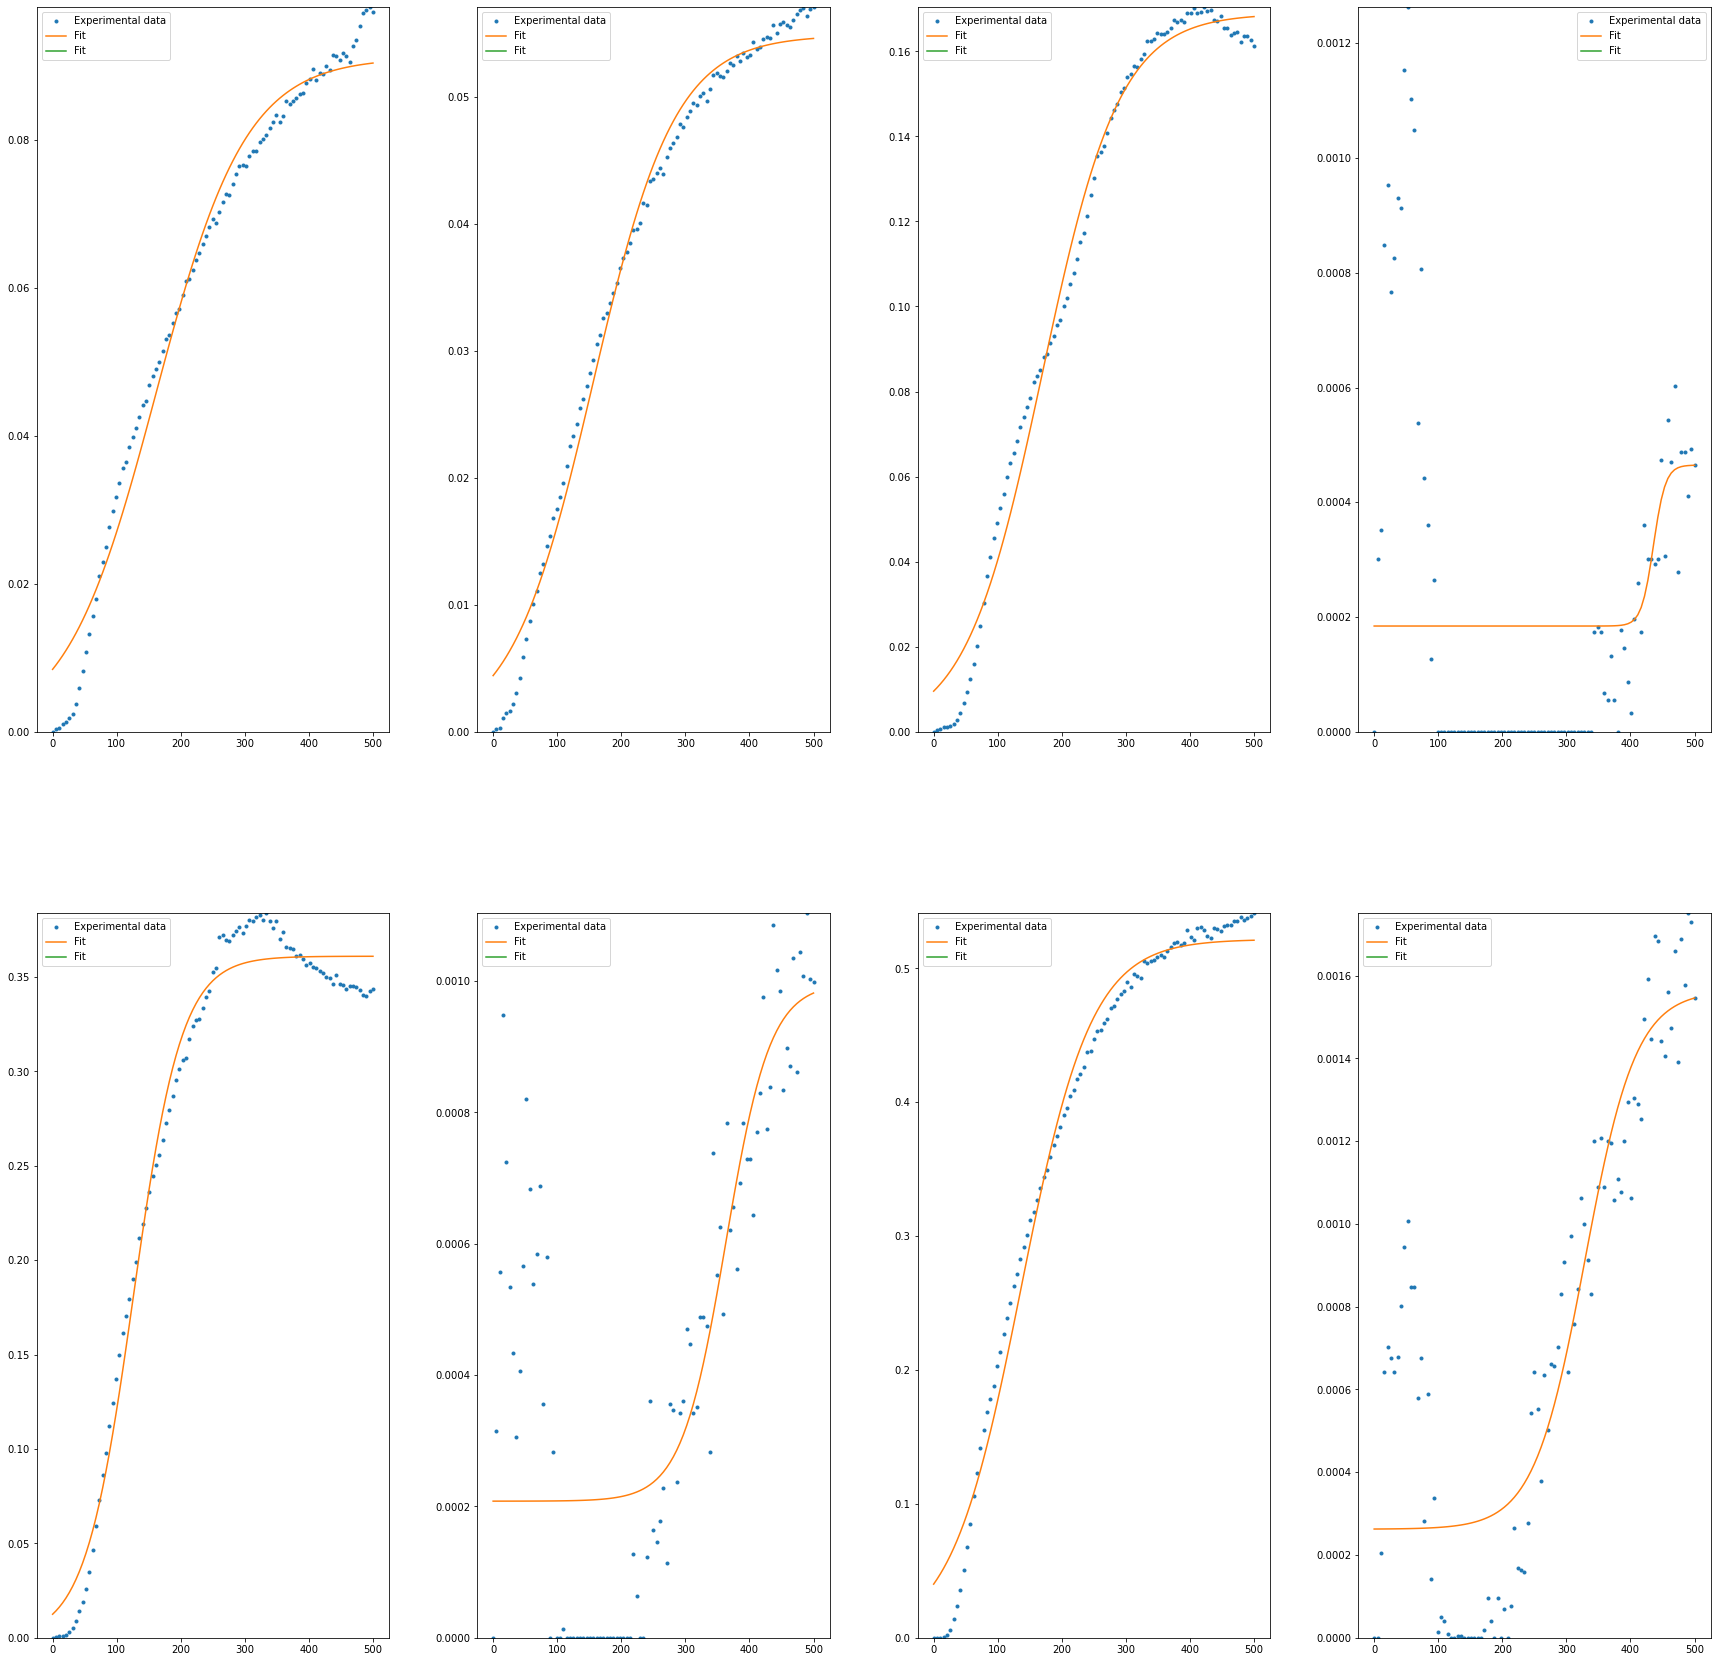

In [8]:
rate = pd.DataFrame()
fig = plt.figure(figsize=(30, 30))

for i in range(rows*columns):
    exec (f"plt.subplot(grid{[i]})")
    popt1,pcov=curve_fit(logifunc,times,ints[ints.columns[i]],method="trf" ,maxfev=10000,
                         bounds = ([0,0,0,min(ints[ints.columns[i]])],[max(ints[ints.columns[i]]),1000,0.2,max(ints[ints.columns[i]])]))
    if r2_score(logifunc(times, *popt1),ints[ints.columns[i]]) < 0.9 :
        rate[name[i]] = 0
    else:
        rate[name[i]] = slope(logifunc(times, *popt1),5)
    plt.plot(times,ints[ints.columns[i]],'.',label='Experimental data')
    plt.plot(times,logifunc(times, *popt1),5,label='Fit')
    plt.ylim(0,max(ints[ints.columns[i]]))
    plt.legend()
    

In [10]:
timemax  = []
counter = 0
for i in rate.columns:
    counter += 1
    for j in rate[i].values:
        if j == alphamax[counter-1]:
            timemax.append(int(rate[rate[i]==j].index.values))
    if np.mean(rate[i].values) == 0:
        timemax.append(0)
print(timemax)

[31, 30, 33, 0, 25, 0, 27, 0]


0.9861133744887438


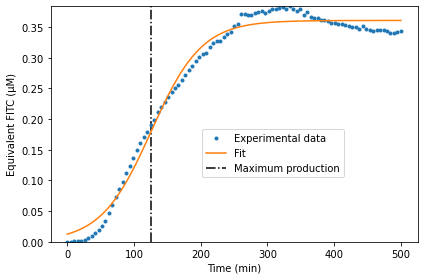

In [11]:
#fig = plt.figure(figsize=(10, 10))
plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = True
plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = False

i = 4 

popt1,pcov=curve_fit(logifunc,times,ints[ints.columns[i]],method="trf" ,maxfev=10000,
                     bounds = ([0,0,0,min(ints[ints.columns[i]])],[max(ints[ints.columns[i]]),1000,0.2,max(ints[ints.columns[i]])]))
print(r2_score(logifunc(times, *popt1),ints[ints.columns[i]]))
plt.plot(times,ints[ints.columns[i]],'.',label='Experimental data')
plt.plot(times,logifunc(times, *popt1),label='Fit')
plt.ylim(0,max(ints[ints.columns[i]]))
plt.xlabel('Time (min)')
plt.ylabel('Equivalent FITC (µM)')
plt.vlines(timemax[i]*5,0,max(ints[ints.columns[i]]),linestyle='-.',color='black',label='Maximum production')
plt.legend(bbox_to_anchor=(0.4,0.5))
plt.tight_layout()
#plt.savefig('plots/Fit.png',dpi=300)
plt.show()

0.9861133744887438


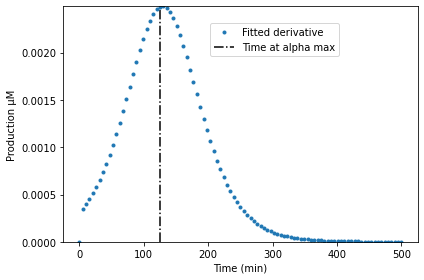

In [12]:
plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = True
plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = False

i = 4 

popt1,pcov=curve_fit(logifunc,times,ints[ints.columns[i]],method="trf" ,maxfev=10000,
                     bounds = ([0,0,0,min(ints[ints.columns[i]])],[max(ints[ints.columns[i]]),1000,0.2,max(ints[ints.columns[i]])]))
print(r2_score(logifunc(times, *popt1),ints[ints.columns[i]]))
#plt.plot(times,ints[ints.columns[i]],'.',label='Experimental data')
#plt.plot(times,logifunc(times, *popt1),label='Fit')
plt.plot(times, slope(logifunc(times, *popt1),5), '.',label='Fitted derivative')
plt.ylim(0,max(slope(logifunc(times, *popt1),5)))
plt.vlines(timemax[i]*5,0,max(slope(logifunc(times, *popt1),5)),linestyle='-.',color='Black',label='Time at alpha max')
plt.xlabel('Time (min)')
plt.ylabel('Production µM')
plt.legend(bbox_to_anchor=(0.4,0.95))
plt.tight_layout()
#plt.savefig('plots/Fit_derivative_time.png',dpi=300)
plt.show()

                  0
Tp901 Not  0.000337
Tp901 ID   0.000223
Bxb1 Not   0.000729
Bxb1 ID    0.000008
Int5 Not   0.002489


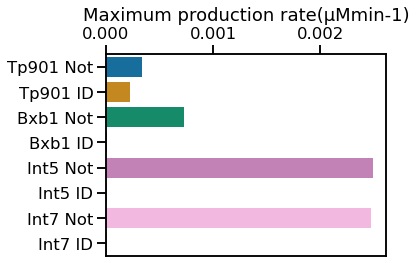

In [13]:
plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = False
plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = True

df = pd.DataFrame()
for i in range(len(name)):
    df[name[i]]=[alphamax[i]]
df = df.T
print(df.head())

sns.set_context('talk')
sns.barplot(y=name,x=df[0].values,palette = 'colorblind')
plt.title('Maximum production rate(µMmin-1)')
plt.tight_layout()
#plt.savefig('plots/maximal_productio_rate.png',dpi=300)
plt.show()

In [14]:
rate

,Tp901 Not,Tp901 ID,Bxb1 Not,Bxb1 ID,Int5 Not,Int5 ID,Int7 Not,Int7 ID
0,0.000000,0.000000,0.000000,0,0.000000e+00,0,0.000000,0
1,0.000117,0.000069,0.000162,0,3.518196e-04,0,0.000732,0
2,0.000124,0.000073,0.000174,0,3.995503e-04,0,0.000792,0
3,0.000131,0.000078,0.000188,0,4.530616e-04,0,0.000856,0
4,0.000139,0.000084,0.000202,0,5.128480e-04,0,0.000924,0
...,...,...,...,...,...,...,...,...
92,0.000015,0.000006,0.000018,0,9.170705e-07,0,0.000020,0
93,0.000014,0.000005,0.000016,0,7.988299e-07,0,0.000018,0
94,0.000013,0.000005,0.000015,0,6.958322e-07,0,0.000016,0
95,0.000012,0.000005,0.000014,0,6.061130e-07,0,0.000015,0


            0
Tp901 Not  31
Tp901 ID   30
Bxb1 Not   33
Bxb1 ID     0
Int5 Not   25


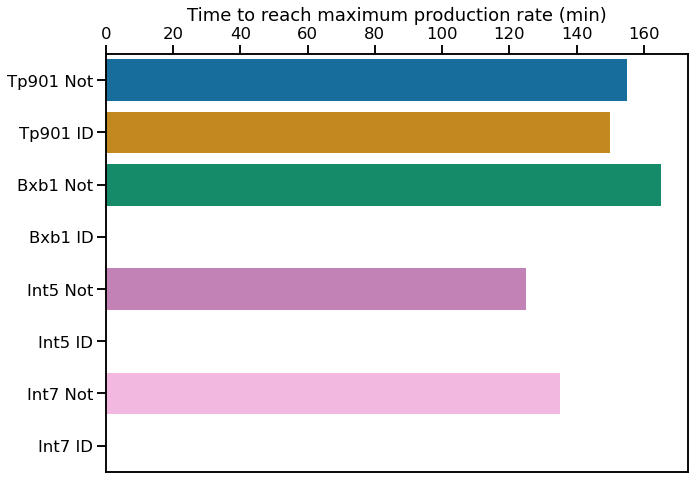

In [22]:
plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = False
plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = True

from matplotlib.pyplot import figure 

figure(figsize=(10,7))

df_2 = pd.DataFrame()
for i in range(len(name)):
    df_2[name[i]]=[timemax[i]]
df_2 = df_2.T
print(df_2.head())

sns.set_context('talk')
sns.barplot(y=name,x=df_2[0].values*5,palette = 'colorblind')
plt.title('Time to reach maximum production rate (min)')#,fontsize=10)
plt.tight_layout()
plt.savefig('plots/time_alpha_max.png',dpi=300)
plt.show()